In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re
import string
from gensim.models import Word2Vec
from gensim.parsing.preprocessing import remove_stopwords
from sklearn.decomposition import PCA
import plotly.graph_objects as go
from sklearn.naive_bayes import GaussianNB, ComplementNB
from sklearn.linear_model import LogisticRegressionCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

import warnings
warnings.filterwarnings('ignore')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
def load_dataset():

    # Load train data
    train = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_train.csv', encoding = "ISO-8859-1")

    # Load test data
    test = pd.read_csv('/content/drive/MyDrive/DLA_dataset/Corona_NLP_test.csv', encoding = "ISO-8859-1")

    return train, test


In [4]:
train, test = load_dataset()

validation = pd.DataFrame(columns=train.columns)
split_by_class = train.groupby('Sentiment')

for group, data in split_by_class:
  split = data.sample(frac=0.2, random_state=200)
  validation = validation.append(split, ignore_index=True)
  train = train.drop(split.index.values.tolist())


num_label_train = train['Sentiment'].value_counts()
num_label_validation = validation['Sentiment'].value_counts()
num_label_test = test['Sentiment'].value_counts()


**Plot distribution of the classes in train set and test set**

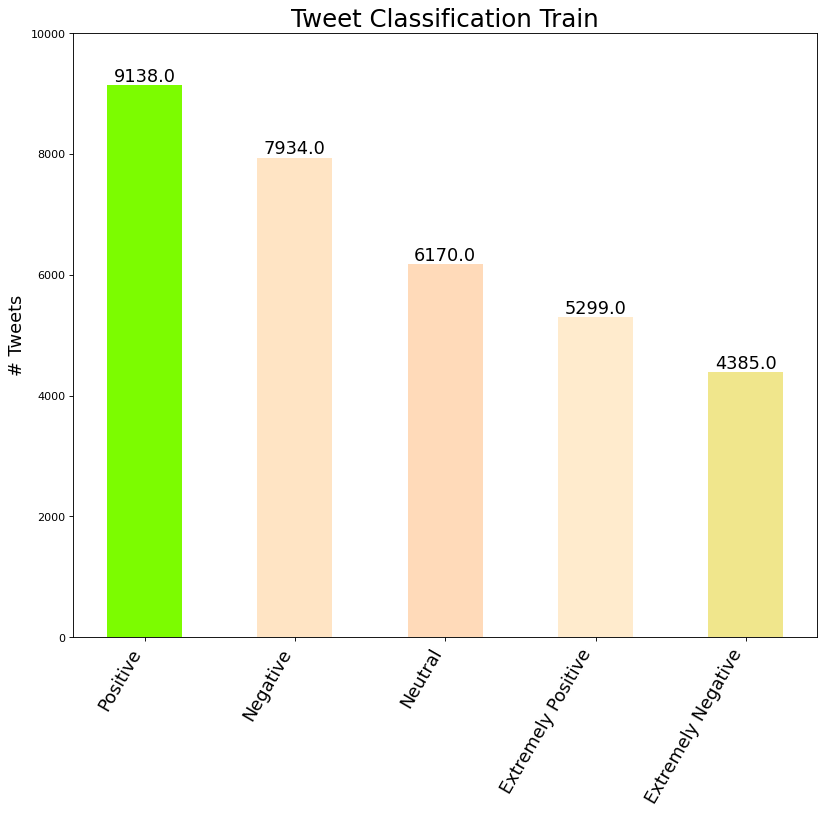

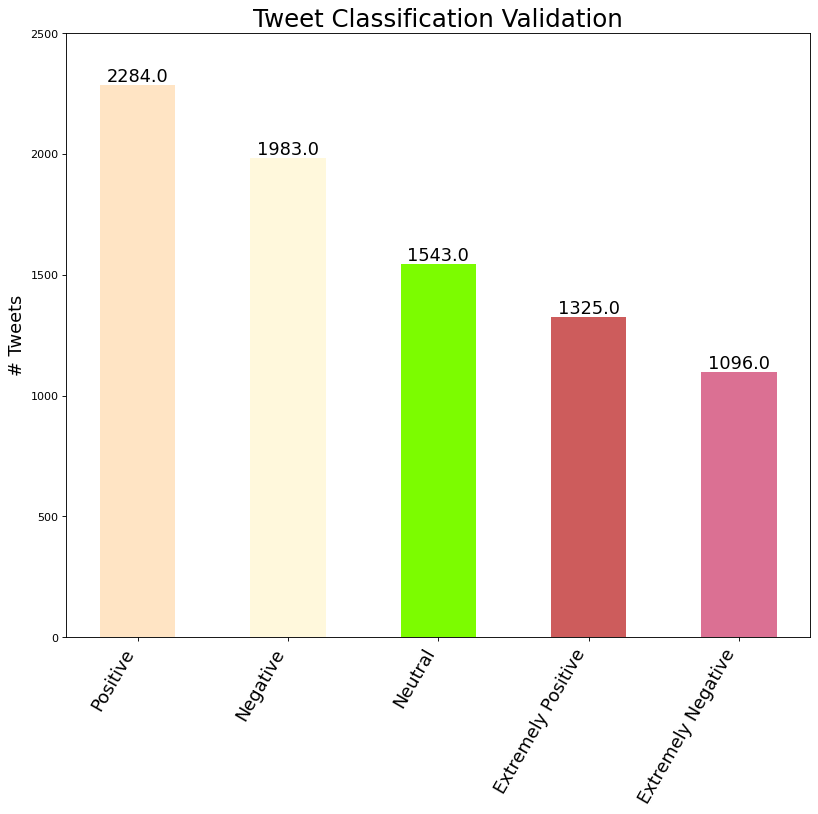

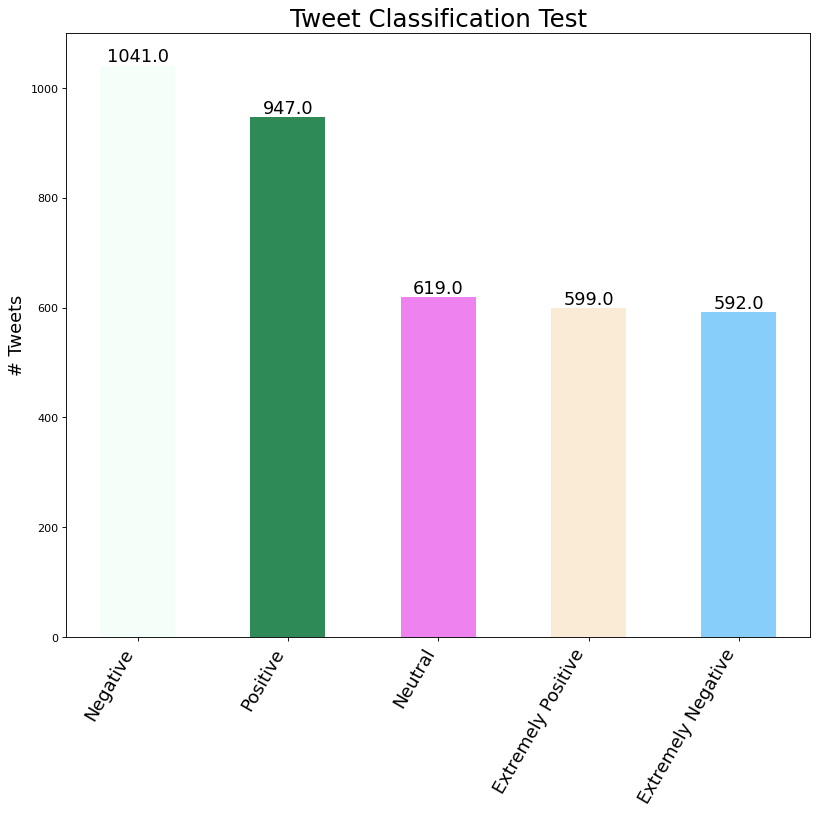

In [5]:
def plot_class_dist(labels, tweets, title, max_item):
  
  all_colors = list(plt.cm.colors.cnames.keys())
  c = np.random.choice(all_colors, 6)

  plt.figure(figsize=(12,10), dpi= 80)

  plt.bar(labels, tweets, color=c, width=.5)
  for i, val in enumerate(tweets):
    plt.text(i, val, float(val), horizontalalignment='center', verticalalignment='bottom', fontdict={'fontweight':500, 'size':16})
  plt.title(title, fontsize=22)
  plt.gca().set_xticklabels(labels, rotation=60, horizontalalignment= 'right', fontsize=16)
  plt.ylabel('# Tweets', fontsize=16)
  plt.ylim(0, max_item)
  plt.show()

plot_class_dist(num_label_train.index, num_label_train.values, "Tweet Classification Train", 10000)
plot_class_dist(num_label_validation.index, num_label_validation.values, "Tweet Classification Validation", 2500)
plot_class_dist(num_label_test.index, num_label_test.values, "Tweet Classification Test", 1100)


**Plot number of words in the tweets**

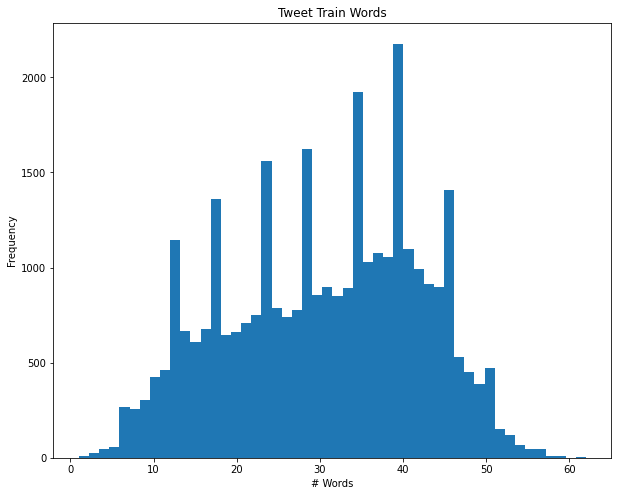

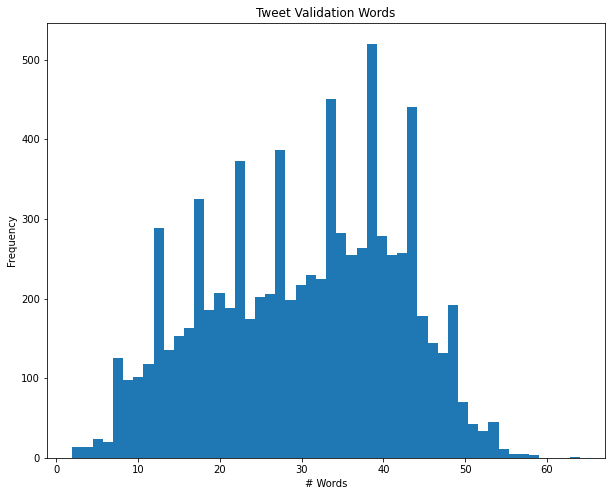

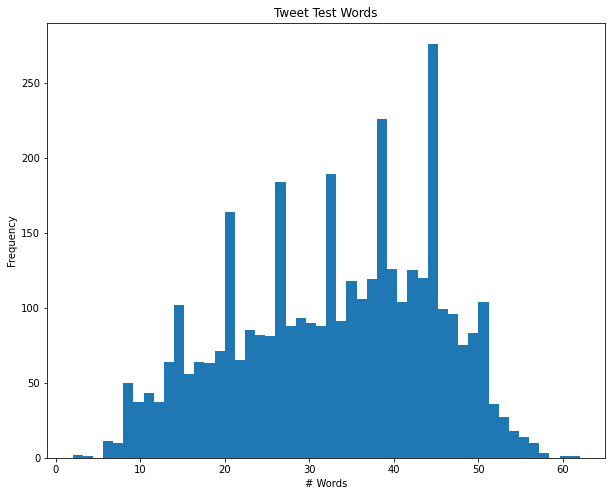

In [6]:
train['TotalWords'] = train['OriginalTweet'].str.lower().str.split().apply(len)
validation['TotalWords'] = validation['OriginalTweet'].str.lower().str.split().apply(len)
test['TotalWords'] = test['OriginalTweet'].str.lower().str.split().apply(len)

train['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Train Words").set_xlabel("# Words")
plt.show()

validation['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Validation Words").set_xlabel("# Words")
plt.show()

test['TotalWords'].plot(bins=50, kind='hist', figsize=(10,8), title="Tweet Test Words").set_xlabel("# Words")
plt.show()


**Pre-Processing**

In [7]:
def pre_processing(df):

  # Remove URL from text
  df['NoURL'] = df['OriginalTweet'].str.replace('http\S+|www.\S+', '', case=False)

  # Remove Tag from text
  df['NoTag'] = df['NoURL'].str.replace('@\S+', '', case=False)

  # Remove punctation from text
  df['NoPunct'] = df['NoTag'].str.translate(str.maketrans('', '', string.punctuation))

  return df


def remove_stop_words(df):
  df['NoStopWords'] = df['NoPunct'].apply(lambda x: remove_stopwords(str(x)))
  df['NoStopWords'].replace('', np.nan, inplace=True)
  df.dropna(subset=['NoStopWords'], inplace=True)
  return df

train = pre_processing(train)
train = remove_stop_words(train)
train['Words'] = train['NoStopWords'].str.split(' ')

test = pre_processing(test)
test = remove_stop_words(test)
test['Words'] = test['NoStopWords'].str.split(' ')

num_label_train = train['Sentiment'].value_counts()
num_label_test = test['Sentiment'].value_counts()


Word2Vec(vocab=58398, size=5, alpha=0.025)
['advice', 'Talk', 'neighbours', 'family', 'exchange', 'phone', 'numbers', 'create', 'contact', 'list', 'schools', 'employer', 'chemist', 'GP', 'set', 'online', 'shopping', 'accounts', 'poss', 'adequate', 'supplies', 'regular', 'meds', 'order', 'Coronavirus', 'Australia', 'Woolworths', 'elderly', 'disabled', 'dedicated', 'hours', 'amid', 'COVID19', 'outbreak', 'My', 'food', 'stock', 'PLEASE', 'dont', 'panic', 'THERE', 'WILL', 'BE', 'ENOUGH', 'FOOD', 'FOR', 'EVERYONE', 'need', 'Stay', 'calm', 'stay', 'safe', 'COVID19france', 'coronavirus', 'confinement', 'Confinementotal', 'ConfinementGeneral', 'As', 'news', 'regionÂ\x92s', 'confirmed', 'case', 'came', 'Sullivan', 'County', 'week', 'people', 'flocked', 'area', 'stores', 'purchase', 'cleaning', 'hand', 'sanitizer', 'toilet', 'paper', 'goods', 'reports', 'Cashier', 'grocery', 'store', 'sharing', 'insights', 'Covid19', 'To', 'prove', 'credibility', 'commented', 'Im', 'Civics', 'class', 'I', 'know'

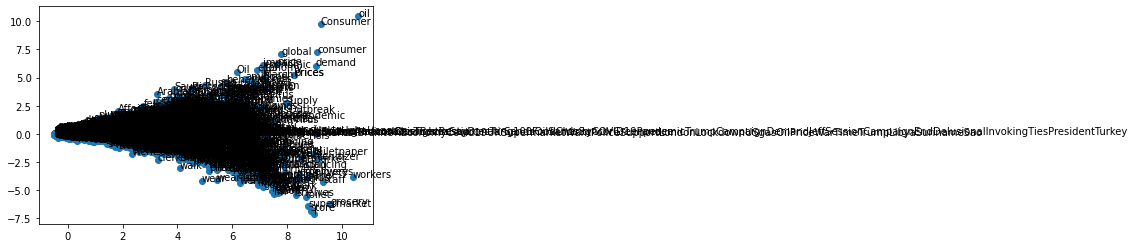

In [8]:
# train word2vec model
w2v = Word2Vec(train['Words'], min_count=1, size = 5)
print(w2v)

#list the vocabulary words
words = list(w2v.wv.vocab)
print(words)
#or show the dictionary of vocab words
w2v.wv.vocab

X = w2v[w2v.wv.vocab]
pca = PCA(n_components=2)
result = pca.fit_transform(X)

# create a scatter plot of the projection
plt.scatter(result[:, 0], result[:, 1])
words = list(w2v.wv.vocab)
for i, word in enumerate(words):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]))

plt.show()


In [36]:
def getEmbedding(list_words, w2v_model):
    word_set = set(w2v_model.wv.index2word)
    X = np.zeros([len(list_words), 5])
    c = 0
    for words in list_words:
        nw=99
        for w in list(reversed(words)):
            if w in word_set:
                X[c] = w2v_model[w]
                nw=nw-1
        c=c+1
    return X


**Baseline**

In [37]:
x_train = getEmbedding(train["Words"], w2v)
x_test = getEmbedding(test["Words"] , w2v)

In [44]:
gnb = GaussianNB()
com = ComplementNB()
y_pred = gnb.fit(x_train, train["Sentiment"].values).predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values == y_pred).sum()))

Number of mislabeled points out of a total 3796 points : 949


In [46]:
clf = LogisticRegressionCV(cv=5, random_state=0).fit(x_train, train["Sentiment"].values)
clf.predict(x_test)
clf.predict_proba(x_test).shape
clf.score(x_test, test["Sentiment"].values)

0.25368809272918863

In [52]:
clf = make_pipeline(StandardScaler(), SVC(gamma='auto'))
clf.fit(x_train, train["Sentiment"].values)
y_pred = clf.predict(x_test)
print("Number of mislabeled points out of a total %d points : %d" % (x_test.shape[0], (test["Sentiment"].values == y_pred).sum()))

Number of mislabeled points out of a total 3796 points : 949
